In [116]:
import pandas as pd
import matplotlib.pyplot as mt
import seaborn as sb
import mysql.connector

db= mysql.connector.connect(host="localhost",
                            user="root",
                            password="123456",
                            database="ecommerce")
cur=db.cursor()
                

# List all unique cities where customers are located.  


In [47]:
query=""" select distinct(customer_city) from customers"""
cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer_City"])
df.head()


,Customer_City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [19]:
query = """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)
data= cur.fetchall()
data[0][0]

180404

 # Find the total sales per category.

In [22]:
query ="""select pt.product_category,round(sum(payment_value),2) from products as pt join order_items as ot on pt.product_id = ot.product_id
join payments as py on py.order_id=ot.order_id group by pt.product_category """

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,sport leisure,5568510.24
1,home appliances,382129.08
2,Furniture office,2587305.95
3,Cool Stuff,3118792.00
4,bed table bath,6850214.68
...,...,...
69,party articles,23865.24
70,La Cuisine,11654.12
71,Fashion Children's Clothing,3142.68
72,insurance and services,1298.04


# Calculate the percentage of orders that were paid in installments.

In [35]:
query= """ select sum(case when payment_installments>=1 then 1 else 0 end)/count(order_id)*100 from payments"""
cur.execute(query)
data =cur.fetchall()
data[0][0]

Decimal('99.9981')

# Count the number of customers from each state.

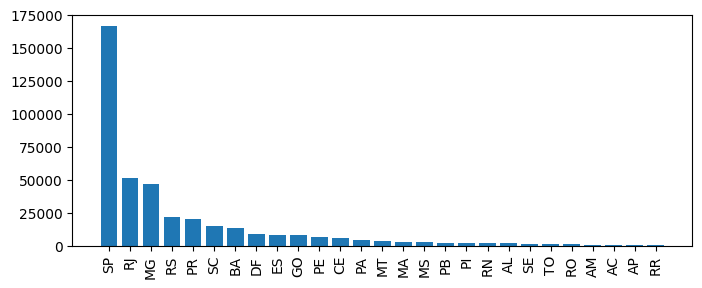

In [46]:
query =""" select customer_state ,count(customer_id)as total_customers from customers 
group by customer_state"""

cur.execute(query)
data =cur.fetchall()
df=pd.DataFrame(data, columns=["customer_state","Total_customers"])
df=df.sort_values(by="Total_customers",ascending =False)
mt.figure(figsize=(8,3))
mt.bar(df["customer_state"],df["Total_customers"])
mt.xticks(rotation =90)
mt.show()

# Calculate the number of orders per month in 2018.

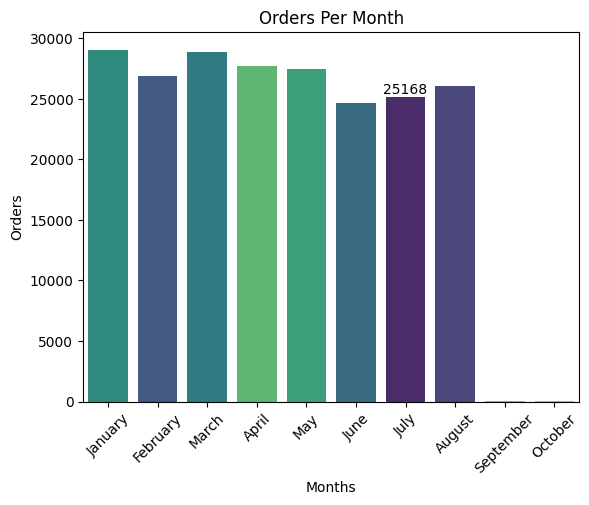

In [107]:
query= """ select monthname(order_purchase_timestamp) order_month ,count(order_id) as order_month from orders where year(order_purchase_timestamp)=2018
group by order_month """
cur.execute(query)
data =cur.fetchall()
df=pd.DataFrame(data,columns=["Months","Orders"])

o=["January","February","March","April","May","June","July","August","September","October"]
ax=sb.barplot(x="Months",y="Orders",data=df,order=o,hue="Months",legend=False ,palette="viridis")
ax.bar_label(ax.containers[0])
mt.xticks(rotation=45)
mt.title("Orders Per Month")
mt.show()


# Find the average number of products per order, grouped by customer city

In [76]:
query=""" with count_per_order as 
(select orders.order_id,orders.customer_id, count(order_items.order_item_id) as c
from orders join order_items on order_items.order_id=orders.order_id 
group by orders.order_id,orders.customer_id)

select customer_state, avg(count_per_order.c)
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer_city","Average_order"])
df.head(10)

,Customer_city,Average_order
0,SC,4.6246
1,SP,4.5872
2,RS,4.5913
3,MG,4.5492
4,RJ,4.5695
5,MT,4.6733
6,PR,4.5938
7,RO,4.5020
8,MS,4.6206
9,BA,4.5253


# Calculate the percentage of total revenue contributed by each product category.

In [88]:
query="""with total_revenue as(
select sum(price*freight_value) as revenue from order_items)

select product_category, round(sum(price*freight_value)/(select * from total_revenue)*100,2) as percentage_category from products join order_items
on products.product_id=order_items.product_id
group by product_category order by percentage_category desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["product_category","Percentage_revenue"])
df.head(10)

,product_category,Percentage_revenue
0,HEALTH BEAUTY,36.05
1,sport leisure,29.54
2,Watches present,24.23
3,bed table bath,23.20
4,housewares,22.46
5,computer accessories,21.33
6,Furniture Decoration,20.30
7,Cool Stuff,20.02
8,automotive,19.86
9,Garden tools,17.07


# Identify the correlation between product price and the number of times a product has been purchased.

In [95]:
import pandas as pd
import matplotlib.pyplot as mt
import seaborn as sb
import mysql.connector
import numpy as np

db= mysql.connector.connect(host="localhost",
                            user="root",
                            password="123456",
                            database="ecommerce")
cur=db.cursor()

query="""select products.product_category, count(order_items.product_id),round(avg(order_items.price),2) as price
from products join order_items on products.product_id=order_items.product_id
group by products.product_category order by price desc"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","count_order","Price"])
arr1=df["count_order"]
arr2=df["Price"]
a=np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is ",a[0][1])


The correlation between product price and the number of times a product has been purchased is  -0.10631514167157557


# Calculate the total revenue generated by each seller, and rank them by revenue.

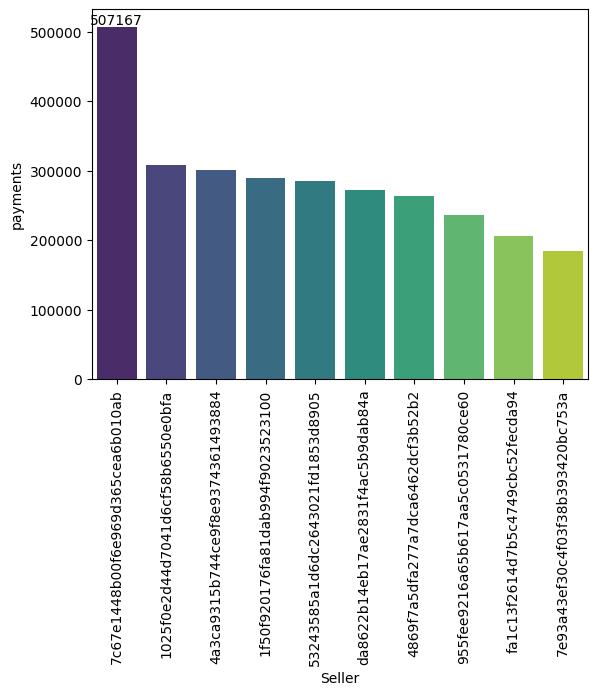

In [111]:
query="""select *,dense_rank() over(order by revenue desc) as d_rank from(
select order_items.seller_id,round(sum(payments.payment_value),2) as revenue
from order_items join payments on order_items.order_id=payments.order_id
group by order_items.seller_id) as t1"""

cur.execute(query)
data =cur.fetchall()
df=pd.DataFrame(data,columns=["Seller","payments","Rank"])
df=df.head(10)
ax=sb.barplot(x="Seller",y="payments",data=df,hue="Seller",palette="viridis")
ax.bar_label(ax.containers[0])
mt.xticks(rotation=90)
mt.show()

# Calculate the moving average of order values for each customer over their order history.

In [113]:
query="""select customer_id,order_purchase_timestamp,avg(payment_value) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as moving_average,payment_value from
(
select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value
from orders join payments on orders.order_id=payments.order_id)as t1"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","Order_History","Moving_Average","Payments"])
df.head(10)


,customer_id,Order_History,Moving_Average,Payments
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998,114.74
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998,114.74
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998,114.74
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998,114.74
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004,67.41
5,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004,67.41
6,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004,67.41
7,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004,67.41
8,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998,195.42
9,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998,195.42


 # Calculate the cumulative sales per month for each year

In [118]:
query="""select years,months,payment,sum(payment) over (order by years,months) as cumulative from(
select year(orders.order_purchase_timestamp) as years,month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments on orders.order_id=payments.order_id
group by years,months order by years,months)as t1"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Year","Month","Sales","Cumulative_sales"])
df.head(10)

,Year,Month,Sales,Cumulative_sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# Calculate the year-over-year growth rate of total sales

In [128]:
query="""select years,(payment-lag(payment) over(order by years))/lag(payment)over(order by years) *100
 from(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments on orders.order_id=payments.order_id
group by years order by years)as t1"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","YOY % growth"])
df

,Years,YOY % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year

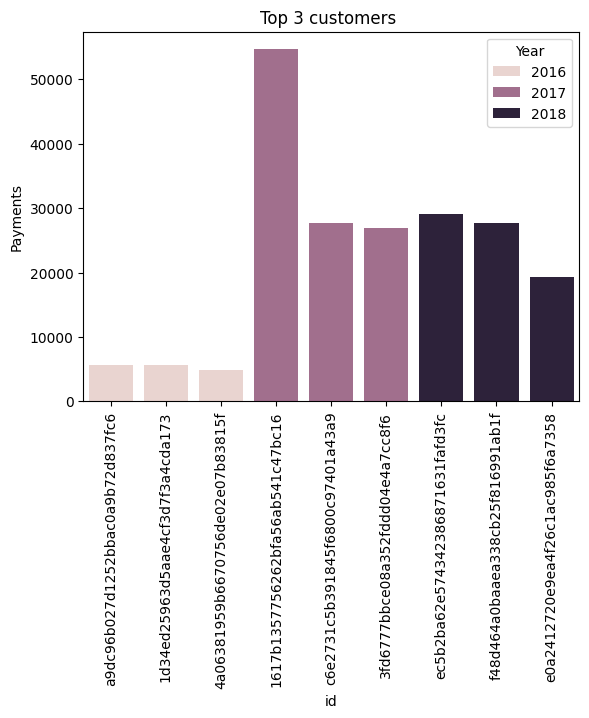

In [133]:
query="""select years,customer_id,payment,d_rank from(
select year(orders.order_purchase_timestamp) years ,orders.customer_id,sum(payments.payment_value) as payment,
dense_rank() over(partition by  year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as d_rank
from orders join payments on orders.order_id=payments.order_id
group by years,orders.customer_id )as t1
where d_rank <=3"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Year","id","Payments","Rank"])
sb.barplot(x="id",y="Payments",data=df,hue="Year")
mt.xticks(rotation=90)
mt.title("Top 3 customers ")
mt.show()

# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [134]:
query="""with a as
(select customers.customer_id,min(orders.order_purchase_timestamp) first_order
from customers join orders on customers.customer_id=orders.customer_id
group by customers.customer_id),
b as
(select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders on a.customer_id=orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp  < date_add(first_order,interval 6 month) 
group by a.customer_id)

select count(distinct a.customer_id)/count(distinct b.customer_id) *100 
from a left join b
on a.customer_id=b.customer_id"""

cur.execute(query)
data=cur.fetchall()
data

[(None,)]